<a href="https://colab.research.google.com/github/DavideRutigliano/DataIntelligenceApplication/blob/master/Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Intelligence Application - Pricing
-----------------------------------------

**Authors:**

* *Davide Rutigliano*


**Project Description**

* Choose a product sold on the Internet. Provide a brief description.

* Imagine an aggregate demand curve aggregating three different demand curves. Provide a description of the three classes of users corresponding to the three disaggregate demand curve. For every disaggregate demand curve, define the phases, providing practical motivations based on market evidence (e.g., seasons), and, for every phase, define the probability distribution, even subject to smooth changes. Note: the definition of the classes of the users must be done by introducing features and different values for the features.

* Define the horizon for the optimization based on market evidence and choose a number of discrete values of the price accordingly.

* Apply to the aggregate demand curve the following algorithms and show, in a plot, how the regret and the reward vary in time:

  * k-testing (choose at beginning the number of samples of the experiment and then apply the hypothesis test);

  * UCB1, TS;

  * SW-UCB1, SW-TS (motivate the length of the sliding window).

* Suppose to apply, the first day of every week, an algorithm to identify contexts and, therefore, to disaggregate the demand curves if doing that is the best we can do. And, if such an algorithm suggests disaggregating the demand curve at time t, then, from t on, keep such demand curves disaggregate. In order to disaggregate the demand curve, it is necessary to reason on the features and the values of the features. Apply the following algorithms and show, in a plot, how the regret and the reward vary in time (also comparing the regret and the reward of these algorithms with those obtained when the algorithms are applied to the aggregate demand curve):

  * UCB1, TS;

  * SW-UCB1, SW-TS (motivate the length of the sliding window).

## Introduction

This project is about the study of A/B testing and Multi-Armed Bandit (MAB) approaches for pricing applications, where a seller needs to identify the best price for a particular kind of item that maximizes the profit without knowing the buyer demand. This is an interesting problem from the seller point of view, since the profit depends by the pricing policy and the best pricing policy is determined by the buyers' preferences, which are usually unknown a priori. In this work we make the assumption that the conversion probability that is, the probability that a buyer purchases the good, is decreasing as the revenue margin is increasing.

We decided to study the case of a laptop sold on the internet.

This type of good is regularly sold all over the year and there are some specific periods (from now on "seasons" or "phases") that are worth to analyse in terms of demands in order to increase the profit in each phase.

We identified three season denoted with *before christmas*, *christmas* and *after christmas*, respectively: the period before christmas (for instance from mid november to start of december), the christmas time (for example from the first days of december up to the 25th) and the period after christmas (from the 26th of december on).

We also differentiate customers basing on their class identifyed by the features.

Features are summarized in the following table:

|Feature| Values         |
|-------|:--------------:|
| Age   | {Young, Old}   |
| Nation| {Italy, USA}   |

Each class can occur with a specific probability, in this study we consider:

* 30% of users are from Italy, 70% are from USA;
* 60% customers are young, the remaining 40% are old.

Thus, we have (for every season) four different probability distribution and disaggregate demand curves, one for each combination of age and gender:

* Italy - Young (18%)
* Italy - Old (12%)
* USA - Young (42%)
* USA - Old (28%)

The probability with which each class can occur is reported in parentesis.

## About the code

We provide here toghether with explainations, formal models and pseudo-code of the algorithms also the results.

Setting ```verbose = True``` plots conversion rates curves for each class per each phase, additional plots such as distributions of the hypotesis and the confusion matrix for A/B tests and info related to the context split.

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import numpy as np
import itertools
import pandas as pd
from scipy import stats
import seaborn as sn

from scipy.interpolate import interp1d

import warnings

# Set verbose = True plots conversion rates curves for each class per 
# each phase and more informations such as distributions in A/B test,
# and other informations related to the context generation

verbose = False #True

Here we define the Context by selecting candidate prices and conversion rates (for each feature in each season) for the calculation the aggregate conversion rates and revenues/aggregate revenues.

We also use this class to sample users' features randomly (or with given probabilities) in order to collect all the customers we are taking into account.

Further explaination will be provided after in the document.

In [0]:
def interpolate(x, y):
    new_x = np.linspace(x.min(), x.max(), 500)
    f = interp1d(x, y, kind='quadratic')
    return new_x, f(new_x)

class Context():
  
  def __init__(self, prices, conversion_rates, features, N=1000):
    
    self.prices = prices
    self.conversion_rates = conversion_rates
    self.features = features

    self.opt_conversion_rates = {"before_christmas":{}, "christmas":{}, "after_christmas":{}}
    self.avg_conversion_rates = {"before_christmas" : {}, "christmas" : {}, "after_christmas" : {}}

    self.calculate_conversion_rates()

    self.revenues = { "before_christmas" : {}, "christmas" : {}, "after_christmas" : {} }
    self.opt_revenues = { "before_christmas" : {}, "christmas" : {}, "after_christmas" : {} }
    self.avg_revenues = {}
    self.opt_avg_revenues = {}

    self.calculate_revenues()

    self.N = N
    self.data = {}
    for f in self.features:
      self.data.update({f : []})
    
  def calculate_conversion_rates(self):
    
    for season in self.conversion_rates.keys():
  
      for a, b in list(itertools.combinations(list(self.features.keys()), r=len(list(self.features.keys())))):
        for f1, f2 in list(itertools.product(self.features[a], self.features[b])):
          self.conversion_rates[season].update({f1+"-"+f2 : np.multiply(conversion_rates[season][f1],
                                                                          conversion_rates[season][f2]).tolist()})

    self.calculate_optimal_conversion_rates()
    self.calculate_average_conversion_rates()
    
  def calculate_optimal_conversion_rates(self):
    
    for season in self.conversion_rates.keys():
      for feature in self.conversion_rates[season].keys():
        self.opt_conversion_rates[season][feature] = np.max(self.conversion_rates[season][feature])
        
  def calculate_average_conversion_rates(self):

    for season in self.conversion_rates:
      for a, b in list(itertools.combinations(list(self.features.keys()), r=len(list(self.features.keys())))):
        self.avg_conversion_rates[season] = np.mean([self.conversion_rates[season][key] for key in [f1+"-"+f2 for f1,f2 in list(itertools.product(self.features[a], self.features[b]))]], axis=0)
            
  def calculate_revenues(self):

    for key, value in self.conversion_rates.items():
      for sub_key, sub_value in value.items():
        self.revenues[key][sub_key] = [conversation_rate * price for conversation_rate, price in zip(sub_value, self.prices)]

    self.calculate_optimal_revenues()
    self.calculate_average_revenues()
    self.calculate_optimal_average_revenue()
    
  def calculate_optimal_revenues(self):

    for key, value in self.revenues.items():
      for sub_key, sub_value in value.items():
        self.opt_revenues[key][sub_key] = (max(sub_value))
      
  def calculate_average_revenues(self):
    
    for key, value in self.avg_conversion_rates.items():
      self.avg_revenues[key] = [avg_conversion_rate * price for avg_conversion_rate, price in zip(value, self.prices)]
      
  def calculate_optimal_average_revenue(self):
    
    for key, value in self.avg_revenues.items():
      self.opt_avg_revenues[key] = (max(value))

  def plot_price_candidates(self):
    
    fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(8,8))
    
    for season, color in zip(self.avg_conversion_rates.keys(), ['r', 'g', 'b']):
      
      smooth_x, smooth_y = interpolate(np.array(self.prices), self.avg_conversion_rates[season])
      axs[0].plot(smooth_x, smooth_y, color, label=season)
      axs[0].scatter(self.prices, self.avg_conversion_rates[season], color=color)
      
      smooth_x, smooth_y = interpolate(np.array(self.prices), self.avg_revenues[season])
      axs[1].plot(smooth_x, smooth_y, color, label=season)
      axs[1].scatter(self.prices, self.avg_revenues[season], color=color)
    
    for pr in prices :
      axs[0].axvline(x=pr, linestyle = "--", lw=1, color='gray')
      axs[1].axvline(x=pr, linestyle = "--", lw=1, color='gray')
    
    axs[0].set_title("Conversion Rate at different candidates prices")
    axs[0].legend()
    axs[1].set_title("Revenue at different candidates prices")
    axs[1].legend()
    plt.show()
    
  def plot_conversion_rates(self, features=None):

    fig, ax = plt.subplots(1, len(self.conversion_rates), figsize=(16,4))
    
    for idx, season in enumerate(self.conversion_rates):   
      
      if features==None:
        features = self.conversion_rates[season]
        
      for feature in features: 
        smooth_x, smooth_y = interpolate(np.array(self.prices), self.conversion_rates[season][feature])
        ax[idx].plot(smooth_x, smooth_y, label=feature)
      
      ax[idx].set_title("CR Curves " + season)
      ax[idx].legend(features)
      ax[idx].set_xlabel("Price (€)")
      ax[idx].set_ylabel("Conversion Rate")
        
    plt.show()
    
  def sample_users(self, N=None):
   
    sample = {}
    
    for f in self.features:
      sample.update({f : []})
    
    if N == None:
      N = self.N
      
    for x in range(N):
      
      for fname in list(self.features.keys()):
        p = np.random.uniform(0,1,1)
        f = list(features[fname].keys())
        
        if p > self.features[fname][f[0]]:
          v = f[1]
        else:
          v = f[0]
        
        sample[fname].append(v)
      
    for f in sample.keys():
      for e in sample[f]:
        self.data[f].append(e)
          
    return self.data
    
  def split(self, mu_c0, p_c1, mu_c1, p_c2, mu_c2):

    if p_c1 * mu_c1 + p_c2 * mu_c2 >= mu_c0:
      return True
    else:
      return False
    
  def update_even_node(self, context, features, p, rev):
      
      if len(features) == 0:
        return context
      
      else:
        fname = list(features.keys())[0]
        f = list(features[fname].keys())
        return self.update_odd_node(context, features, fname, f, p, rev)
        
  def update_odd_node(self, context, features, fname, f, p, rev):

    c_val = list(context.values())[0]

    if (self.split(c_val, p[f[0]], rev[f[0]], p[f[1]], rev[f[1]])):

      if p[f[0]] * rev[f[0]] >= p[f[1]] * rev[f[1]]:
        f1 = f[0]
        context = {f1 : rev[f[0]]}

      else:
        f1 = f[1]
        context = {f1 : rev[f[1]]}

    features.pop(fname)

    return self.update_even_node(context, features, p, rev)
  
  def split_context(self, season_index=0):
      
    season = list(self.opt_revenues.keys())[season_index]
    
    total = len(self.data[list(self.features.keys())[0]])

    bound_factor = np.sqrt(-1 * np.math.log(0.95) / (2 * total))
    
    p = {}
    for fname in self.features.keys():
      for f in self.features[fname]:
        p.update({f : self.data[fname].count(f) / np.array(total) - np.array(bound_factor)})
    
    rev = {}
    for f in self.revenues[season]:
      rev.update({f : np.max(np.array(list(self.opt_revenues[season].values())) / np.array([self.prices[i] for i in [np.argmax(self.revenues[season][f])]])) - np.array(bound_factor)})    

    c0 = np.max(self.opt_avg_revenues[season] / self.prices[np.argmax(self.opt_revenues[season])]) - bound_factor
    
    context = {'aggregate' : c0}
    
    context = self.update_even_node(context, self.features.copy(), p, rev)

    return list(context.keys())[0]

## Time Horizon and Sliding Window

We decided to run the experiment for a time period of 50 days, considering an average number of 24 customers per day. Thus, the horizon of our experiment (that is, the total number of users), $T \in \mathbb{N}$ is: $T = 50 \times 24 = 1200$ (customers).

Subsequently, we define the number of candidates prices according to the formula:

$K = \lfloor\sqrt[4]{T \cdot log(T)}\rfloor$

We define here this parameters for practical reasons, because we use them to calculate demands and conversion rates for the k prices; in a real-world use case, once the number of candidates is defined one should simply take k prices and the respective conversion rates, then calculate the revenues.

For completeness, we also define here the number of phases, the phase length and the sliding window size.

The sliding window should be proportional to the square root of the time horizon ( $\tau \propto \sqrt{T}$ ) and cannot depends on unknown parameters.

In this work we decided to use $\tau = 15 \cdot \sqrt{T}$ that is slightly bigget than the phase lenght (about $40\%$ of the time horizon).

In [3]:
T = 1200

k = int(np.round(pow(T * np.log(T), 1/4)))

n_phases = 3
phases_len = int(T/n_phases)
print("Time Horizon: %d; Number of Candidates: %d;\nNumber of Phases: %d; Phase Lenght: %d." % (T, k, n_phases, phases_len))

window_size = 15 * int(np.sqrt(T))
print("Size of the sliding-window: %d." % (window_size))

Time Horizon: 1200; Number of Candidates: 10;
Number of Phases: 3; Phase Lenght: 400.
Size of the sliding-window: 510.


## Formal Model

The formal model definition is:

* $p \in \mathbb{R}^+$ price

* $q(p)$ aggregate demand for price p

* $c(q(p))$ cost (for seller) of q(p) items, in this experiment we consider $c(q(p)) = 0, \forall p$

* $p q(p)$ revenue at price p

* $p q(p) - c(q(p))$ profit at price p

The objective of the seller is of course the profit maximization.

Given the prices (or "candidates"), the probability with which each feature can occur and the conversion rate of each feature for each season, we can calculate the probability distribution for each class of customers for each season.

Furthermore, we calculate the revenue without taking into account of the cost of the item sold (for the seller) that is, in our case the revenue is the same as the profit. The problem can be easily extended to the before-christmas one (where there's a cost for the seller for the item sold) by subtracting the cost from the revenue.

Conversion rates and revenues are reported in plots below.

In [0]:
# We take k linearly spaced samples for prices, starting from a price of 880$ to 
# a price of 1155$.

prices = list(np.linspace(880, 1155, k))

features = {
    "country" : {"italy" : .3,
                 "usa" : .7},
    "age" : {"young" : .6,
             "old" :.4}
}

# We create "fake" conversion rates, always k probabilities (one per price).

# In order to have not linearly spaced values here (and therefore a demand with 
# always the same slope) we use a little trick that is appending a list of some
# non linearly spaced values (for example 2 values) to a list of k-2 linearly
# spaced values.

conversion_rates = {

  "before_christmas" : {

    "italy" : list(np.append([0.8, 0.7], np.linspace(.67, .65, k-2))),
    "usa" : list(np.append([0.82, 0.78], np.linspace(.61, .5, k-2))),
    "young" : list(np.append([0.8, 0.75], np.linspace(.65, .46, k-2))),
    "old" : list(np.append([0.9, 0.8], np.linspace(.67, .55, k-2)))
   },

  "christmas" : {

    "italy" : list(np.append([0.67, 0.57], np.linspace(.44, .32, k-2))),
    "usa" : list(np.append([0.77, 0.67], np.linspace(.63, .54, k-2))),
    "young" : list(np.append([0.79, 0.73], np.linspace(.66, .45, k-2))),
    "old" : list(np.append([0.81, 0.77], np.linspace(.69, .58, k-2)))
   },

  "after_christmas" : {

    "italy" : list(np.append([0.78, 0.67], np.linspace(.57, .45, k-2))),
    "usa" : list(np.append([0.9, 0.75], np.linspace(.66, .35, k-2))),
    "young" : list(np.append([0.74, 0.65], np.linspace(.58, .35, k-2))),
    "old" : list(np.append([0.85, 0.67], np.linspace(.47, .35, k-2)))
  }
}

### Summary

Here we summarize the (aggregate) conversion rates and revenues in a plot where the dotted lines represent the different candidate prices.

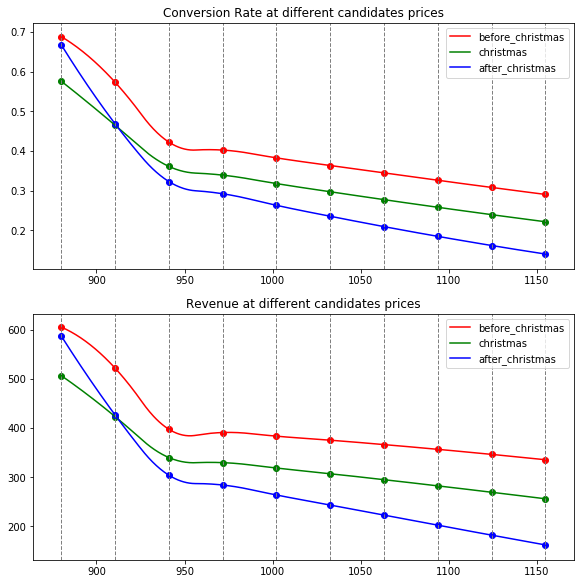

In [5]:
context = Context(prices, conversion_rates, features)

context.plot_price_candidates()

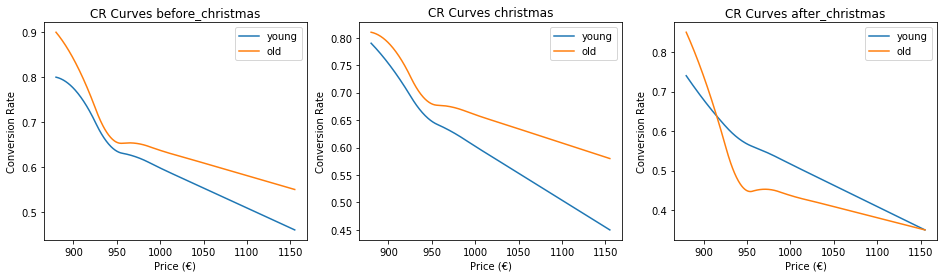

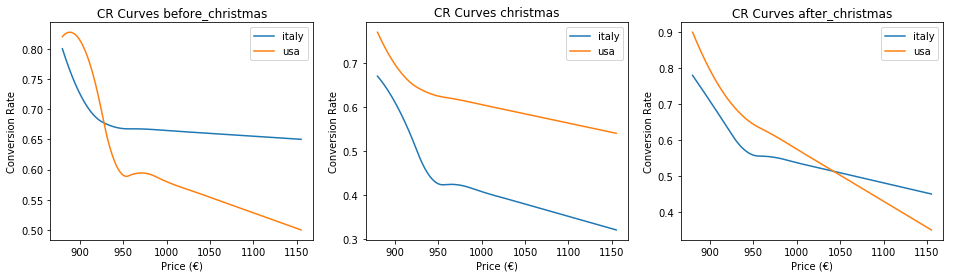

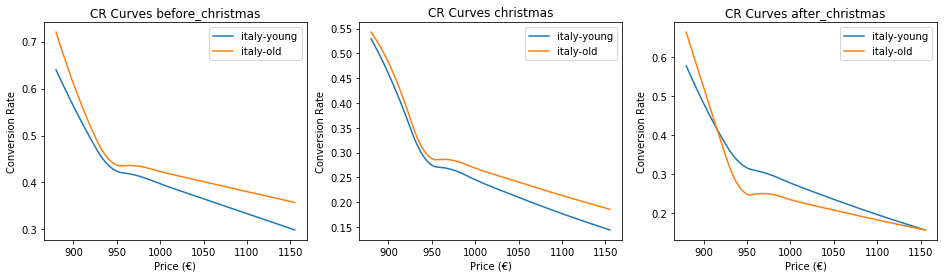

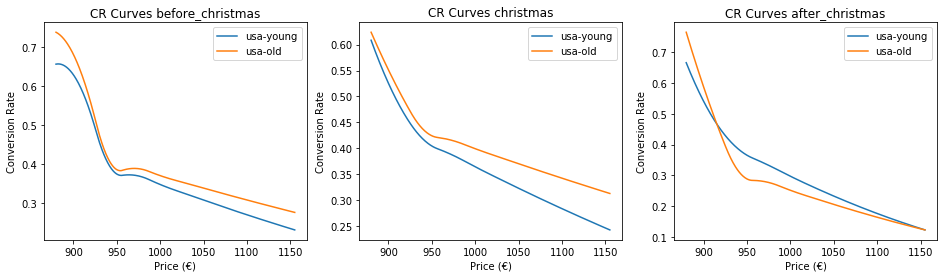

In [6]:
if True:
  context.plot_conversion_rates(features=['young', 'old'])
  context.plot_conversion_rates(features=['italy', 'usa'])
  context.plot_conversion_rates(features=['italy-young', 'italy-old'])
  context.plot_conversion_rates(features=['usa-young', 'usa-old'])

## Algorithms

In this section we provide pseudo-code and relative implementation of the algorithms used for the experiment.

### Environment and Learner

The Environment is aimed at simulating the single experiment by returning a reward ($r \in \{0,1$\} with the meaning of not-buying/buying the item). The reward is the realization of a Bernoulli random variable of parameter p, where p is the conversion rate at a given price.

The Non Stationary Environment does the same but taking into account also of the time t and of the current phase. Thus, the parameter p of the Bernoulli rv is the conversion rate of a given price in a specific phase.

In [0]:
class Environment():
  
  def __init__(self, n_arms, probabilities):
    
    self.n_arms = n_arms
    self.probabilities = probabilities

  def round(self, pulled_arm):
    
    p = self.probabilities[pulled_arm]
    
    return np.random.binomial(1, p)
  
class Non_Stationary_Environment(Environment):
  
  def __init__(self, n_arms, probabilities, horizon):
    
    super().__init__(n_arms, probabilities)
    self.t = 0
    self.horizon = horizon
    
  def round(self, pulled_arm):
    
    n_phases = len(self.probabilities)
    phase_size = self.horizon/n_phases
    current_phase = int(self.t/phase_size)
    p = self.probabilities[current_phase][pulled_arm]
    self.t += 1

    return np.random.binomial(1, p)

### A/B Testing

We explain here all the steps of A/B testing. We decided to implement Sequential A/B test.

* Generate data:

  We randomly generate data for the experiment by using a Bernoulli random variable (of parameter the conversion rate associated to the candidate price) to simulate that an user buy or not the product at a given price with a given probability.
  
  **Note:** if $X\sim \mathcal{B}({p})$, then $\mathbb{E}[X] = p$ and $\mathrm{VAR}[X] = p(1-p)$

* Formulate hypotesis:

  We are considering two candidates at time in order to have a test that states if one candidate is better than the other or not.
  
  In order to take into account of both conversion rates and prices and therefore select the candidate that gives to the seller the highest revenue, we weighted the conversion rate (the probability of buying or not buying) for the price.

  We first define the means of (the Bernoulli random variable associated to) candidate $C_{1}$ and $C_{2}$  weighting the conversion rates for the prices, i.e. $\bar{X_{2}} = \mu_{C_{2}} = \frac{cr_{2} \times p_{2}}{p_{1} + p_{2}}$ and $\bar{X_{1}} = \mu_{C_{1}} = \frac{cr_{1} \times p_{1}}{p_{1} + p_{2}}$.
  
  $p_{1}$ and $p_{2}$ are the prices of respectively variant 1 and variant 2.

  Then the hypotesis:

Name       |Symbol             |                                                       Values|
:----------|:-----------------:|-----------------------------------------------------------:|
Null       | $\mathcal{H}0$   |$\mu_{C_{2}}$ $-$ $\mu_{C_{1}}$ $= 0$|
Alternative| $\mathcal{H}1$   |$\mu_{C_{2}}$ $-$ $\mu_{C_{1}}$ $\geq \delta$|

* Test statistic:

  The idea behind this test statistic is this: we have two normal distributions the null hypotesis and the alternative hypotesis. We consider the value $z$ that is the realization of the random variable $Z$ defined below: it represent the empirical difference between the two candidates divided by the pooled standard deviation. When this value is smaller than the $95\%$ of the null hypotesis we accept $\mathcal{H}0$, otherwise we decide for $\mathcal{H}1$.
  
  $Z = \frac{\bar{X_{2}} - \bar{X_{1}}}{\sqrt{\bar{Y}\times(1-\bar{Y})\times\left(\frac{1}{n_{1}} + \frac{1}{n_{2}}\right)}}$
  
  where the pooled mean:
  
  $\bar{Y} = \frac{n_{1}\bar{X_{1}} + n_{2}\bar{X_{2}}}{n_{1} + n_{2}}$

* Choose accuracy of test statistics:

  We decided to use an accuracy that is typical for A/B testing, that is $95\%$ , or equivalently a *I-type error* probability of $5\%$. The I-type error probability is often denoted as $\alpha$ (or significance level) and it represent the probability of rejecting the null hypotesis when it's true (false positive rate).
  
  The other paraemeter we set before the experiment is the power of the test $1 - \beta = 80\%$ and the subsequent *type-II error* or false negative rate, given by $\beta = 20\%$.
  
* Select random samples:

  We first calculate the minimum number of samples needed for the test, then we set the number of samples of our experiment to be at least the minimum sample size.
  
  Given $\alpha$ and $\beta$ defined above, the standard deviation of the process $\sigma$ and the minimum variation $\delta$, we have:
  
  $n = \frac{(z(1-\alpha) + z(\beta))^2 \sigma^2}{\delta^2}$
  
  where $z(q)$ is the value of the gaussian distribution for quantile $q$.
  
  **Note:** in order to calculate the standard deviation and the minimum difference between candidates we also used the conversion rates weighted for the selling prices.

* Calculate test statistics on given samples.

In [0]:
def plot_norm_dist(mean, var, label):
  
  x = np.linspace(mean - 12 * var, mean + 12 * var, 1000)
  y = stats.norm(mean, var).pdf(x)
  plt.plot(x, y, label=label)
  
class AB_Test():
  
  def __init__(self, arms, variants, sigma, delta, alpha=0.05, beta=0.8):
        
    self.arms = arms
    self.variants = variants
    self.alpha_quantile = stats.norm.ppf(1-alpha, loc=0, scale=1)
    self.beta_quantile = stats.norm.ppf(beta, loc=0, scale=1)
    self.verbose = False
    
    self.min_n = np.zeros((len(variants), len(variants)))
    for i in range(len(variants)):
      for j in range(len(variants)):
        if i != j:
          self.min_n[i][j] = ((self.alpha_quantile + self.beta_quantile) * sigma[i][j] / delta[i][j]) ** 2
      
  def setup_parameters(self, n_control, n_test):
    
    if n_control == None:
      self.N_a = int(self.min_n[self.c_1][self.c_2]) + 1
    else:
      self.N_a = n_control
      
    if n_test == None:
      self.N_b = int(self.min_n[self.c_1][self.c_2]) + 1
    else:
      self.N_b = n_test
    
    if self.verbose:
      print("Sample size for A/B test:", self.N_a, self.N_b)

    if(self.N_a < self.min_n[self.c_1][self.c_2] or self.N_b < self.min_n[self.c_1][self.c_2]):
      warnings.warn("Sample size should be at least the minimum sample size: " + str(int(self.min_n[self.c_1][self.c_2]) + 1))
      
  def test(self):
    
    self.z = (self.mu_2 - self.mu_1) / self.sigma
    if self.verbose:
      print("z-score for a/b test is:", self.z)

  def p_value(self):
    
    p_val = 1 - stats.norm(0, self.sigma).cdf(self.sigma * self.z)
    if self.verbose:
      print("p-value for a/b test is:", p_val)
    
  def confidence_interval(self, mean=0, var=1):
    
    left = mean - self.alpha_quantile * var
    right = mean + self.alpha_quantile * var
    
    return (left, right)
   
  def plot_confusion_matrix(self, alpha, beta):
    
    a = pd.Series(["H0 True", "H1 True"], name="Truth")
    b = pd.Series(["Not Rejecting H0", "Rejecting H0"], name="Action")
    df = pd.crosstab(b, a)
    df["H0 True"]["Not Rejecting H0"] = 100 * (1.0 - alpha)
    df["H0 True"]["Rejecting H0"] = 100 * (alpha)
    df["H1 True"]["Not Rejecting H0"] = 100 * (beta)
    df["H1 True"]["Rejecting H0"] = 100 * (1.0 - beta)

    plt.figure()
    sn.heatmap(df, annot=True, fmt='.3f', cmap=plt.cm.Blues)
    plt.show()
    
  def plot(self):
    
    left, right = self.confidence_interval(var=self.sigma)
    
    plt.axvline(left, linestyle='--', alpha=0.5)
    plt.axvline(right, linestyle='--', alpha=0.5)
    
    plt.xlim(4 * left, 4 * right)
    
    plot_norm_dist(0, self.sigma, "H0")
    plot_norm_dist(self.delta, self.sigma, "H1")
    plt.legend()
    
    x = np.linspace(-12 * self.sigma, 12 * self.sigma, 1000)
    
    null = stats.norm(0, self.sigma)
    alternative = stats.norm(self.delta, self.sigma)
    
    power = 1 - alternative.cdf(right)
    
    plt.fill_between(x, 0,
                    alternative.pdf(x),
                    color='green', alpha='0.25', where=(x > right))
    
    plt.text(0, null.pdf(0),
            'power = {0:.3f}'.format(power),
            fontsize=12, ha='right', color='k')
    
    alpha = 1 - null.cdf(right)
    beta = alternative.cdf(right)
    
    self.plot_confusion_matrix(alpha, beta)
    
  def run_experiment(self, conversion_rates, N=None, plot=False, verbose=False):
    
    self.verbose = verbose
    
    v_1 = self.variants[0]
    rewards = [[] for v in range(len(self.variants)-1)]
    arms = [[] for v in range(len(self.variants)-1)]
    
    for v_2 in self.variants[1:]:
  
      if self.verbose:
        print("Variant", v_1, "vs.", v_2)
  
      self.c_1 = self.variants.index(v_1)
      self.c_2 = self.variants.index(v_2)
                  
      ab_test = self.setup_parameters(N, N)
      
      N_tot = self.N_a + self.N_b
      self.X = [[] for i in range(2)]
      env = Environment(2, [conversion_rates[self.c_1], conversion_rates[self.c_2]])

      for i in range(N_tot):
        
        pulled_arm = int(i % 2)
        
        reward = env.round(pulled_arm)
        self.X[pulled_arm].append(reward)
        
        rewards[self.variants.index(v_2)-1].append(reward)
        arms[self.variants.index(v_2)-1].append(pulled_arm)

      self.mu_1 = np.mean(self.X[0]) * self.arms[self.c_1] / (self.arms[self.c_1] + self.arms[self.c_2])
      self.mu_2 = np.mean(self.X[1]) * self.arms[self.c_2] / (self.arms[self.c_1] + self.arms[self.c_2])

      self.delta = self.mu_2 - self.mu_1

      y = (self.N_a * self.mu_1 + self.N_b * self.mu_2) / (self.N_a + self.N_b)
      self.sigma = np.sqrt(y * (1 - y) * (1/self.N_a + 1/self.N_b))
      self.test()
      self.p_value()
      
      if plot:
        plt.figure()
        self.plot()
        
        if self.verbose:
          print("Revenues A/B:",
                "\n* Variant A:", str(np.round(conversion_rates[self.c_1] * self.arms[self.c_1], 2)) + "$",
                "\n* Variant B:", str(np.round(conversion_rates[self.c_2] * self.arms[self.c_2], 2)) + "$", 
                "\n* Difference:", str(np.round(conversion_rates[self.c_2] * self.arms[self.c_2] - conversion_rates[self.c_1] * self.arms[self.c_1], 2)) + "$",
                "\n* Percentage:", str(np.round((conversion_rates[self.c_2] * self.arms[self.c_2] - conversion_rates[self.c_1] * self.arms[self.c_1])/(conversion_rates[self.c_1] * self.arms[self.c_1]), 2)*100) + "%")

      if self.z > self.alpha_quantile:
        if self.verbose:
          print("Test is significant! We reject null hypotesis in favour of:", v_2)
        v_1 = v_2

      if self.verbose:
        print()
    
    if self.verbose:
      print("Variant", v_1, "is better")
    
    return rewards, arms

### Bandits

In the set up we proposed, the goal is to design a pricing policy that minimizes the regret (the loss the seller get by choosing a non optimal arm), or equivalently that maximize the profit, and that is able to converge to the optimal price.

We provide here formal models and pseudo-code of the following Multi Armed Bandits algorithms:

* Upper Confidence Bound - 1
* Thompson Sampling
* Sliding Window Upper Confidence Bound - 1
* Sliding Window Thompson Sampling


The Learner class is a common class for bandits aimed at collecting the rewards and the arms pulled at each round as explained in next sections.

In [0]:
 class Learner():
  
  def __init__(self, n_arms, arms):
    
    self.n_arms = n_arms
    self.arms = arms    
    self.t = 0
    self.rewards = []
    self.arm_pulled = []

  def update_observation(self, pulled_arm, reward):
    
    self.rewards.append(reward)
    self.arm_pulled.append(pulled_arm)

#### Upper Confidence Bound One

* *Notation*

  $t$ time

  $A$ set of arms

  $a$ arm

  $a_{t}$ arm played at time $t$

  $a^*$ optimal arm

  $X_{a}$ random variable (bernoulli) associated to arm a

  $\mu_{a}$ expected value of random variable $X_{a}$

  $x_{a,t}$ realization of rv $X_{a}$ at time $t$

  $x_{a}$ realizations of $X_{a}$

  $\bar{x}_{a}$ empirical mean of $x_{a}$

  $n_{a}(t)$ number of samples of arm $a$ at time $t$


* *Pseudocode*

  * Play once each arm $a \in A$

  * At every time $t$ play arm $a$ such that:

    $a_{t} \leftarrow \DeclareMathOperator*{\argmax}{arg\,max}
  \argmax_a{\left\{\left[\bar{x}_{a} + \sqrt{\frac{2 log(t)}{{n_{a}(t-1)}} }\right]\times a\right\}}$



#### Sliding Window Upper Confidence Bound One

* *Notation*

  $t$ time

  $\tau$ sliding window

  $\{b_{1}, ..., b_{m}\}$ breakpoints

  $A$ set of arms

  $a$ arm

  $a_{t}$ arm played at time $t$

  $a_{t}^*$ optimal arm at time $t$

  $X_{a,t}$ random variable (bernoulli) associated to arm a

  $\mu_{a,t}$ expected value of random variable $X_{a}$

  $x_{a,t}$ realization of rv $X_{a}$ at time $t$ 

  $\bar{x}_{a,t,\tau}$ empirical mean of $x_{a}$ computed with samples in $\{t - \tau,..., t\}$

  $n_{a}(t,\tau)$ number of samples of arm $a$ at time $t$ in $\{t - \tau,..., t\}$

* *Pseudocode*

  * Play once each arm $a \in A$

  * At every time $t$ play arm $a$ with ${n_{a}(t) = 0}$ if any, otherwise play arm $a$ sucht that:

    $a_{t} \leftarrow \DeclareMathOperator*{\argmax}{arg\,max}
  \argmax_a{\left\{\left[\bar{x}_{a,t,\tau} + \sqrt{\frac{2 log(t)}{{n_{a}(t-1, \tau)}} }\right]\times a\right\}}$
  
  
  The idea behind these algorithms is that at each round the arm (price) with the highest upper confidence bound value (multiplied by the corresponding price) is chosen in order to maximize the total revenue among all the possible arms.

In [0]:
class UCB1_Learner(Learner):
  
  def __init__(self, n_arms, arms):
    
    super().__init__(n_arms=n_arms, arms=arms)
    self.pulling_times = [0] * n_arms 
    self.reward = [1] * n_arms 
    
  def pull_arm(self):
    
    for arm in range(self.n_arms):
      if self.pulling_times[arm] == 0: 
        return arm
    
    confidences = np.sqrt(2 * np.log(self.t) / np.array(self.pulling_times[self.arm_pulled[self.t-1]]))     
    avg_values = np.array(self.reward) / np.array(self.pulling_times) 
    
    UCB = np.array(self.arms) * (avg_values + confidences)
    
    idx = np.argmax(UCB)
        
    return idx
  
  def update(self, pulled_arm, reward):
    
    self.update_observation(pulled_arm, reward)
    self.pulling_times[pulled_arm] += 1
    self.reward[pulled_arm] += reward
    self.t += 1
    
class SW_UCB1_Learner(UCB1_Learner):
  
  def __init__(self, n_arms, arms, window_size):
    
    super().__init__(n_arms=n_arms, arms=arms)
    self.window_size = window_size
  
  def update(self, pulled_arm, reward):
    
    self.update_observation(pulled_arm, reward)
    self.pulling_times[pulled_arm] += 1
    self.reward[pulled_arm] += reward
    
    if self.t > self.window_size:
      self.reward[self.arm_pulled[self.t-self.window_size]] -= self.rewards[self.t-self.window_size]
      self.pulling_times[self.arm_pulled[self.t-self.window_size]] -= 1
    
    self.t += 1

#### Thompson Sampling

* *Notation* (in addition to the one of classical UCB1)
  
  $\mathbb P(\mu_{a}=\theta_{a})$ prior of the expected value of $X_{a}$
  
  $\theta_{a}$ variable of $\mathbb P(\mu_{a}=\theta_{a})$
  
  $(\alpha_{a_{t}}, \beta_{a_{t}})$ parameters of the beta distribution $P(\mu_{a}=\theta_{a})$
  
* *Pseudocode*

  * At every time $t$ for every arm $a$:
  
    $\tilde{\theta_{a}} \leftarrow Sample(\mathbb P(\mu_{a}=\theta_{a}))$

  * At every time $t$ play arm $a_{t}$ such that
  
    $a_{t} \leftarrow \DeclareMathOperator*{\argmax}{arg\,max}
  \argmax_a \left\{ \tilde{\theta_{a}} \times a \right\} $

  * Update beta distribution of arm $a_{t}$
  
    $(\alpha_{a_{t}}, \beta_{a_{t}}) \leftarrow (\alpha_{a_{t}}, \beta_{a_{t}}) + (x_{a_{t},t}, 1 - x_{a_{t},t})$
  

#### Sliding Window Thompson Sampling Pseudocode

* *Notation* is the same as above (in addition to the one of sliding window UCB1)

* *Pseudocode*

  * At every time $t$ for every arm $a$:
  
    $\tilde{\theta_{a}} \leftarrow Sample(\mathbb P(\mu_{a}=\theta_{a}))$

  * At every time $t$ play arm $a_{t}$ such that
  
    $a_{t} \leftarrow \DeclareMathOperator*{\argmax}{arg\,max}
  \argmax_a \left\{ \tilde{\theta_{a}} \times a \right\} $

  * Update beta distribution of arm $a_{t}$
  
    if $t < \tau :(\alpha_{a_{t}}, \beta_{a_{t}}) \leftarrow (\alpha_{a_{t}}, \beta_{a_{t}}) + (x_{a_{t},t}, 1 - x_{a_{t},t})$
    
    if $t > \tau: (\alpha_{a_{t}}, \beta_{a_{t}}) \leftarrow \max \left\{(1,1), (\alpha_{a_{t}}, \beta_{a_{t}}) + (x_{a_{t},t}, 1 - x_{a_{t},t}) - (x_{a_{t-\tau},t-\tau}, 1 - x_{a_{t-\tau},t-\tau})\right\}$
    
The idea behind these algorithms is that at each round the arm (price) with the highest value of the prior (multiplied by the corresponding price) is chosen in order to maximize the total revenue among all the possible arms.

In [0]:
class TS_Learner(Learner):
  
  def __init__(self, n_arms, arms):
    
    super().__init__(n_arms=n_arms, arms=arms)
    self.beta_param = np.ones((n_arms, 2))

  def pull_arm(self):

    idx = np.argmax(np.array(self.arms) * np.random.beta(self.beta_param[:,0], self.beta_param[:,1]))
    return idx

  def update(self, pulled_arm, reward):
    
    self.update_observation(pulled_arm, reward)
    self.beta_param[pulled_arm, 0] = self.beta_param[pulled_arm, 0] + reward
    self.beta_param[pulled_arm, 1] = self.beta_param[pulled_arm, 1] + 1.0 - reward
    self.t += 1
     
    
class SW_TS_Learner(TS_Learner):
  
  def __init__(self, n_arms, arms, window_size):
    
    super().__init__(n_arms=n_arms, arms=arms)
    self.window_size = window_size

  def update(self, pulled_arm, reward):
    
    self.update_observation(pulled_arm, reward)
    self.beta_param[pulled_arm, 0] = self.beta_param[pulled_arm, 0] + reward
    self.beta_param[pulled_arm, 1] = self.beta_param[pulled_arm, 1] + 1.0 - reward
    
    if self.t > self.window_size:
      self.beta_param[pulled_arm, 0] = max(self.beta_param[pulled_arm, 0] - self.rewards[self.t-self.window_size], 1.0)
      self.beta_param[pulled_arm, 1] = max(self.beta_param[pulled_arm, 1] - 1.0 + self.rewards[self.t-self.window_size], 1.0)
        
    self.t += 1

## Results

### Utils

In [0]:
def plot_histogram(values, n_arms, axs, title, size):
  
  axs.hist(values + np.array(1), bins=range(1, n_arms+2))
  axs.set_title(title)
  axs.set_xlabel('Arm')
  axs.set_ylabel('Attempts')
  axs.xaxis.set_major_locator(MaxNLocator(integer=True))
  
def plot_results(T, phase_len, n_experiments, istantaneous_reward, clairvoyant, arms, n_arms, algorithm):
    
  size = (4*int(T/phases_len), 4)
  fig, axs = plt.subplots(1, int(T/phases_len), figsize=size, sharey=True)
  
  for i in range(int(T/phases_len)):
    arm_per_experiment = []
    
    for k in range(n_experiments):
      arm_per_experiment.append(arms[k][i*phases_len : (i+1)*phases_len])
    
    plot_histogram(np.array(stats.mode(arm_per_experiment, axis=0)[0]).reshape(phases_len), n_arms, axs[i], "Arm Selection (phase " + str(i+1) + ")", size)
  
  plt.figure()
  plt.plot(range(T), istantaneous_reward, label=algorithm, zorder=5)
  plt.plot(range(T), clairvoyant, "--", label='clairvoyant', zorder=10, color='C1')
  plt.title(algorithm + " Instantaneous Reward")
  plt.xlabel('Time')
  plt.ylabel('Expected Reward')
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(range(T), clairvoyant - istantaneous_reward)
  plt.title(algorithm + " Instantaneous Regret")
  plt.xlabel('Time')
  plt.ylabel('Regret')
  plt.show()

  plt.figure()
  plt.plot(range(T), np.cumsum(istantaneous_reward), label=algorithm, zorder=5)
  plt.plot(range(T), np.cumsum(clairvoyant), "--", label='clairvoyant', zorder=10, color='C1')
  plt.title(algorithm + " Cumulative Reward")
  plt.xlabel('Time')
  plt.ylabel('Expected Reward')
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(range(T), np.cumsum(clairvoyant - istantaneous_reward))
  plt.title(algorithm + " Cumulative Regret")
  plt.xlabel('Time')
  plt.ylabel('Regret')
  plt.show()
  
def compare_results(ax, T, rewards, clairvoyant):

  ax[0].plot(range(T), np.cumsum(clairvoyant), "--", label='clairvoyant', zorder=10, color='C1')
  
  colors = ["C0", "C2", "C3", "C4", "C5"]
  for algorithm in rewards:
    ax[0].plot(range(T), np.cumsum(rewards[algorithm]), label=algorithm, color=colors[list(rewards.keys()).index(algorithm)])
  
  ax[0].set_title("Cumulative Reward")
  ax[0].set_xlabel('Time')
  ax[0].set_ylabel('Expected Reward')
  ax[0].legend()

  for algorithm in rewards:
    ax[1].plot(range(T), np.cumsum(np.array(clairvoyant) - np.array(rewards[algorithm])), label=algorithm, color=colors[list(rewards.keys()).index(algorithm)])
    
  ax[1].set_title("Cumulative Regret")
  ax[1].set_xlabel('Time')
  ax[1].set_ylabel('Regret')
  ax[1].legend()
  
def run_experiment(learner, T, prices, probabilities):

  env = Non_Stationary_Environment(len(prices), probabilities=probabilities, horizon=T)
  
  for t in range(T):
    pulled_arm = learner.pull_arm()
    reward = env.round(pulled_arm)
    learner.update(pulled_arm, reward)

### A/B Testing

For showing results we plot the distributions of the hypotesis and the confidence interval of $H0$ in order to graphically show the power of the test; furthermore we plot the confusion matrix for the I- and II- type error probabilities (in $\%$) and calculate the p-value, defined as the area of the normal distribution associated to the null hypotesis given the value of the test statistic $z$.

As explained above, before running the tests we first set the I- and II- type error probabilites ($5\%$ and $20\%$ in this case) and then calculate the standard deviation $\sigma$ and the minimum difference $\delta$ between the probabilities of each pair of candidates, in order to calculate the minimum number of samples needed for each test.

We can observe that when the difference between the candidates tested (A/B) is not very high (as for example with candidates 4 vs. 5, 5 vs. 6 and so on) the number of samples required in order to reach the desired confidence/power is very high (for example variants D vs. C in phase 2 where the difference in revenue is $3\%$ and the number of samples required is *60931*) with respect to tests comparing candidates with bigger differences in probabilities (for instance variants C vs. B in phase 2 where the difference in the total revenue is $25\%$ and the number of samples is *991*).

This essentially points out the fact that A/B Testing can require a very large amount of samples when the difference in probabilities is not big enough and, more in general, that A/B testing is not suitable for this type of problems as it will require a very large amount of samples to converge to the optimium.

Following results can be read as follows:

* z-score is the value of the test statistics

* p-value is the area under the null hypotesis where the distribution is greater than the z-score

* the first plot shows how the two hypotesis are distributed and the power of the test that is, the area under the alternative hypotesis where the distribution is greater than the $95\%$ of the null hypotesis

* the second plot shows the confusion matrix for the A/B test showing the true error rates (useful for summarizing results and checking that fixing the number of samples to the minimum number plus one we reach the desired power $\beta$ )

**Note**: we test the candidates in reverse order (from last to first).

In [13]:
for i in range(n_phases):
  
  print("\nPhase:", str(i+1), "\n\n")
  
  A = prices
  
  probabilities = list(context.avg_conversion_rates.values())[i]
    
  variants = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "L"]
  
  probabilities = probabilities[::-1]
  variants = variants[::-1]
  A = A[::-1]
  
  sigmas = np.zeros((len(variants),len(variants)))
  deltas = np.zeros((len(variants),len(variants)))
    
  for k in range(len(variants)):
    for j in range(len(variants)):
      if k != j:
        m_1 = probabilities[k] * A[k] / (A[k] + A[j])
        m_2 = probabilities[j] * A[j] / (A[k] + A[j])
        sigmas[k][j] = sigmas[j][k] = np.sqrt(m_1 * (1 - m_1) + m_2 * (1 - m_2))
        deltas[k][j] = deltas[j][k] = m_1 - m_2
    
  ab_test = AB_Test(A, variants, sigma=sigmas, delta=deltas)
  
  np.random.seed(1234)

  ab_test.run_experiment(probabilities, plot=verbose, verbose=True)


Phase: 1 


Variant L vs. I
Sample size for A/B test: 68166 68166
z-score for a/b test is: 3.095534350726411
p-value for a/b test is: 0.0009822930777723116
Test is significant! We reject null hypotesis in favour of: I

Variant I vs. H
Sample size for A/B test: 76171 76171
z-score for a/b test is: 2.500761566951146
p-value for a/b test is: 0.006196329052310157
Test is significant! We reject null hypotesis in favour of: H

Variant H vs. G
Sample size for A/B test: 86090 86090
z-score for a/b test is: 3.231873379278088
p-value for a/b test is: 0.0006149076897470351
Test is significant! We reject null hypotesis in favour of: G

Variant G vs. F
Sample size for A/B test: 98686 98686
z-score for a/b test is: 2.623307199291629
p-value for a/b test is: 0.004354035783764698
Test is significant! We reject null hypotesis in favour of: F

Variant F vs. E
Sample size for A/B test: 115152 115152
z-score for a/b test is: 3.1523586148551526
p-value for a/b test is: 0.0008097861617840652
Test is signif

As we can see, when using $\frac{T}{2}$ as minimum number of samples in A/B testing (in order to have total number of samples for each test equal to 1200, that is the horizon for other experiments) we get very low precision and high p-values. We can also notice that the algorithm does not reach the optimum at all.

We run the experiment for 100 independent runs then we average the results (we also average results on the phases because A/B testing works only in stationary environments).

**Note**: histograms are not really meaningful in this case as they will result as always pulling the same number of times ($N = \frac{T}{2} = 600$ in this case) the first 2 arms (because we compare arms one by one).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Sample size should be at least the minimum sample size: 8120
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Sample size should be at least the minimum sample size: 2031
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Sample size should be at least the minimum sample size: 903
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Sample size should be at least the minimum sample size: 8102
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Sample size should be at least the minimum sample size: 2023
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Sample size should be at least the minimum sample size: 898
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Sample size should be at least the minimum sample size: 8017
/usr/local/lib/python3.6/dist

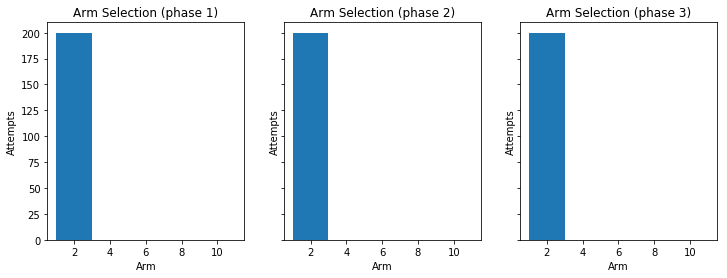

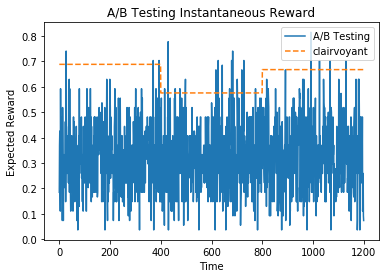

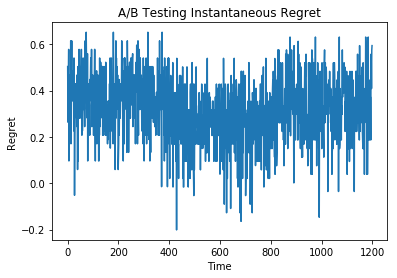

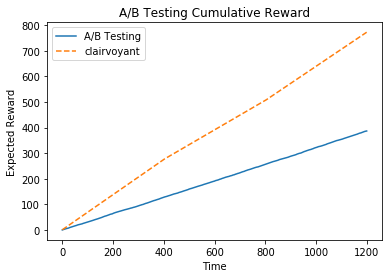

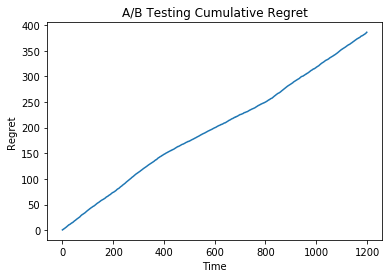

In [14]:
n_experiments = 100

ab_rewards = [[[] for i in range(n_phases)] for e in range(n_experiments)]
arms = [[[] for i in range(n_phases)] for e in range(n_experiments)]

for exp in range(n_experiments):
  for i in range(n_phases):
    np.random.seed(1234)
    probabilities = list(context.avg_conversion_rates.values())[i]

    variants = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "L"]

    probabilities = probabilities[::-1]
    variants = variants[::-1]
    A = A[::-1]

    sigmas = np.zeros((len(variants),len(variants)))
    deltas = np.zeros((len(variants),len(variants)))

    for k in range(len(variants)):
      for j in range(len(variants)):
        if k != j:
          m_1 = probabilities[k] * A[k] / (A[k] + A[j])
          m_2 = probabilities[j] * A[j] / (A[k] + A[j])
          sigmas[k][j] = sigmas[j][k] = np.sqrt(m_1 * (1 - m_1) + m_2 * (1 - m_2))
          deltas[k][j] = deltas[j][k] = m_1 - m_2
        
    ab_test = AB_Test(A, variants, sigma=sigmas, delta=deltas)
    r, a = ab_test.run_experiment(probabilities, N=T//2)
    ab_rewards[exp][i].append(r)
    arms[exp][i].append(a)
  
opt_per_phase = np.max(list(context.avg_revenues.values()), axis=1) / np.array([prices[i] for i in np.argmax(list(context.avg_revenues.values()), axis=1)])
clairvoyant = []

for i in range(n_phases):
  clairvoyant.append([opt_per_phase[i]] * phases_len)

clairvoyant = clairvoyant[0] + clairvoyant[1] + clairvoyant[2]

plot_results(T, phases_len, n_experiments, np.array(np.mean(np.mean(np.mean(np.mean(ab_rewards, axis=0), axis=1), axis=0), axis=0)), clairvoyant, np.array(stats.mode(stats.mode(arms, axis=1)[0], axis=3)[0]).reshape((n_experiments, T)), len(prices), "A/B Testing")

### Bandits

We run for each algorithm 100 indipendent experiments and then average the results.

Given a policy $\mathfrak{U}$, we define the instantaneous reward and regret as the difference between the optimal candidate (clairvoyant solution) and the expected value of the reward given by the MAB:

* $\mathbb{E}\left[\mu_{a_{t}}\right]$
* $R_{t}\left(\mathfrak{U}\right) = T \mu_{a}^* - \mathbb{E}\left[\mu_{a_{t}}\right]$

And cumulative (or pseudo-) reward and regret, respectively:

* $\mathbb{E}\left[\sum_{t=1}^{T}{\mu_{a_{t}}}\right]$
* $R_{T}\left(\mathfrak{U}\right) = T \mu_{a}^* - \mathbb{E}\left[\sum_{t=1}^{T}{\mu_{a_{t}}}\right]$

Where $\mu_{a}^*$ is the (optimal) value provided by the clairvoyant algorithm.

We show here results, after the execution of each algorithm, in 4 different plots respectively:

* Instantaneous Reward vs. Clayrvoiant
* Instantaneous Regret
* Cumulative Reward vs. Clayrvoiant
* Cumulative Regret

We also provide the histograms of the arm selection for each phase (taking the mode of the arms pulled in each experiment in that phase, i.e. the most pulled arm phase among all the experiments).

Then in next section, we show in 2 separated plots the comparison between all the algorithms in terms of Cumulative Rewards and Cumulative Regrets.

In [0]:
results = {
    "A/B_TEST": np.array(np.mean(np.mean(np.mean(np.mean(ab_rewards, axis=0), axis=1), axis=0), axis=0)),
    "UCB1" : [],
    "SW_UCB1" : [],
    "TS" : [],
    "SW_TS" : []
}


opt_per_phase = np.max(list(context.avg_revenues.values()), axis=1) / np.array([prices[i] for i in np.argmax(list(context.avg_revenues.values()), axis=1)])
clairvoyant = []

for i in range(n_phases):
  clairvoyant.append([opt_per_phase[i]] * phases_len)

clairvoyant = clairvoyant[0] + clairvoyant[1] + clairvoyant[2]

#### Upper Confidence Bound

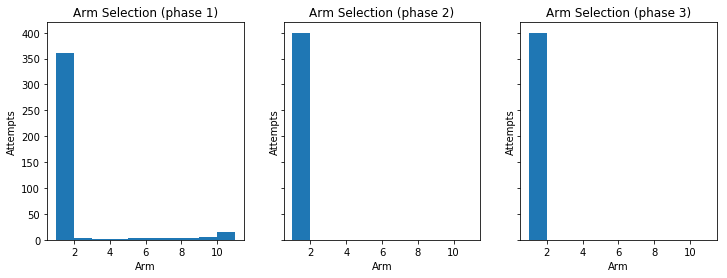

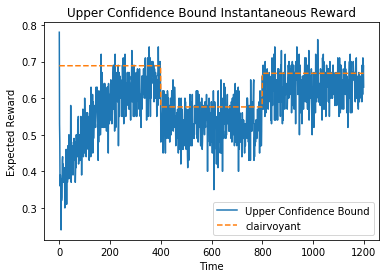

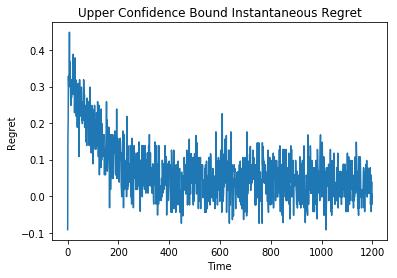

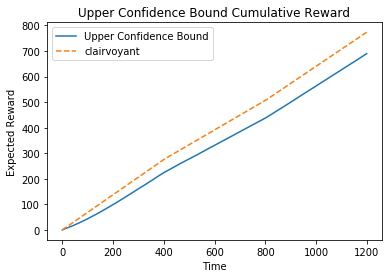

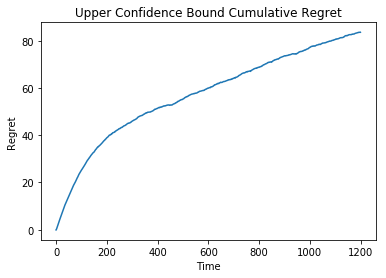

In [16]:
np.random.seed(1234)

probabilities = list(context.avg_conversion_rates.values())

n_experiments = 100

arms = []
rewards = []

for i in range(n_experiments):
  learner = UCB1_Learner(n_arms=len(prices), arms=prices)
  run_experiment(learner, T, prices, probabilities)
  arms.append(learner.arm_pulled)
  rewards.append(learner.rewards)

results["UCB1"].append(np.mean(rewards, axis=0))

plot_results(T, phases_len, n_experiments, np.array(np.mean(rewards, axis=0)), clairvoyant, np.array(arms), len(prices), "Upper Confidence Bound")

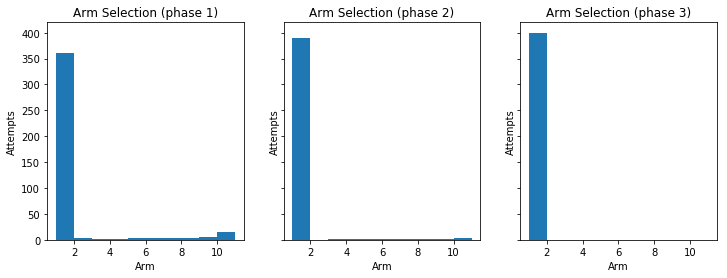

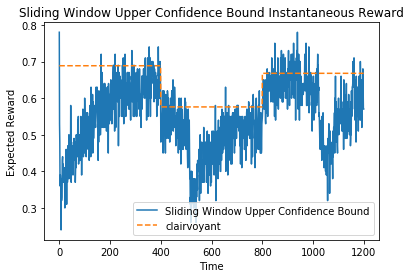

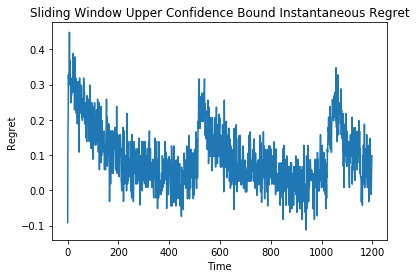

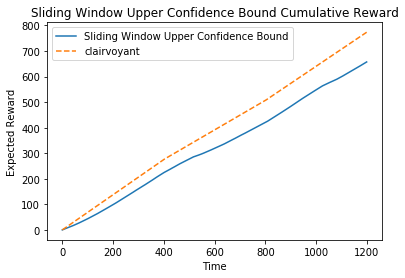

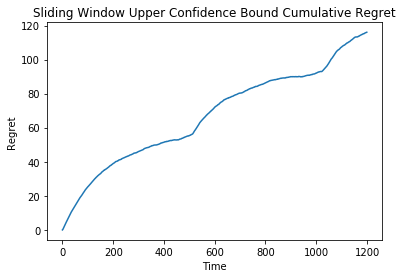

In [17]:
np.random.seed(1234)

probabilities = list(context.avg_conversion_rates.values())

arms = []
rewards = []

n_experiments = 100

for i in range(n_experiments):
  learner = SW_UCB1_Learner(n_arms=len(prices), arms=prices, window_size=window_size)
  run_experiment(learner, T, prices, probabilities)
  arms.append(learner.arm_pulled)
  rewards.append(learner.rewards)

results["SW_UCB1"].append(np.mean(rewards, axis=0))

plot_results(T, phases_len, n_experiments, np.array(np.mean(rewards, axis=0)), clairvoyant, np.array(arms), len(prices), "Sliding Window Upper Confidence Bound")

#### Thompson Sampling

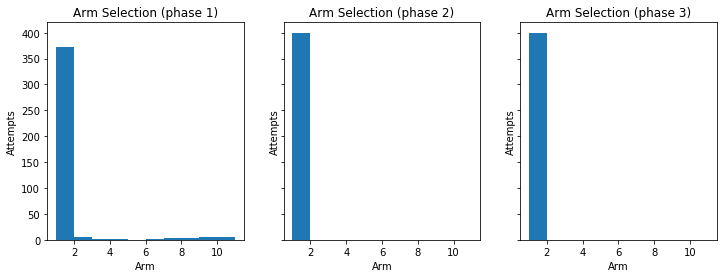

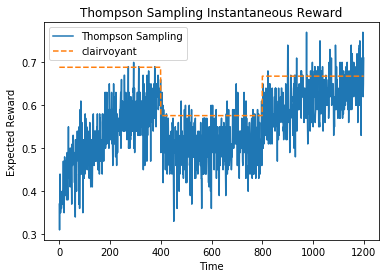

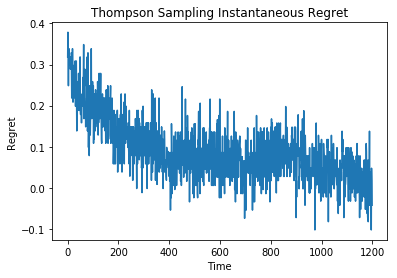

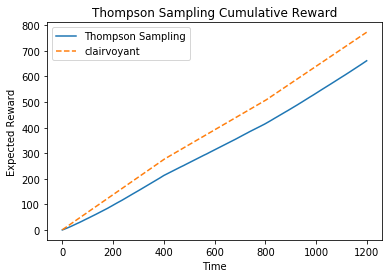

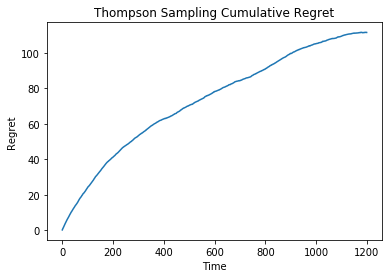

In [18]:
np.random.seed(1234)

probabilities = list(context.avg_conversion_rates.values())

arms = []
rewards = []

n_experiments = 100

for i in range(n_experiments):
  learner = TS_Learner(n_arms=len(prices), arms=prices)
  run_experiment(learner, T, prices, probabilities)
  arms.append(learner.arm_pulled)
  rewards.append(learner.rewards)

results["TS"].append(np.mean(rewards, axis=0))

plot_results(T, phases_len, n_experiments, np.array(np.mean(rewards, axis=0)), clairvoyant, np.array(arms), len(prices), "Thompson Sampling")

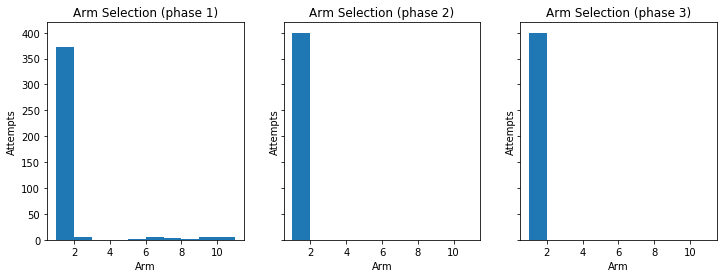

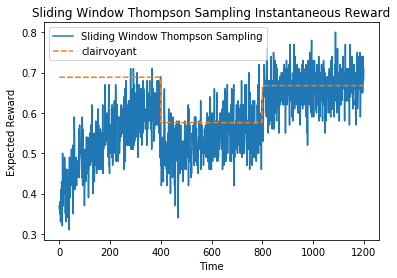

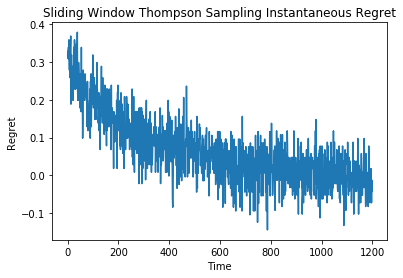

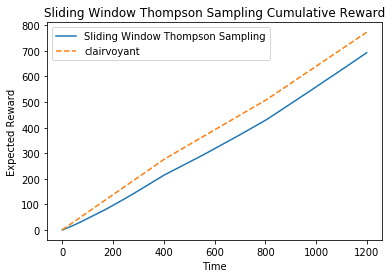

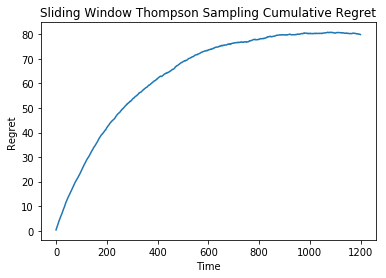

In [19]:
np.random.seed(1234)

probabilities = list(context.avg_conversion_rates.values())

arms = []
rewards = []

n_experiments = 100

for i in range(n_experiments):
  learner = SW_TS_Learner(n_arms=len(prices), arms=prices, window_size=window_size)
  run_experiment(learner, T, prices, probabilities)
  arms.append(learner.arm_pulled)
  rewards.append(learner.rewards)

results["SW_TS"].append(np.mean(rewards, axis=0))

plot_results(T, phases_len, n_experiments, np.array(np.mean(rewards, axis=0)), clairvoyant, np.array(arms), len(prices), "Sliding Window Thompson Sampling")

#### Comparison

We can observe that UCB-1 performs slightly better than TS, because UCB-1 uses the number of times an arm has been pulled during past explorations to estimate the upper bounds and for this reason the algorithms performs very well when the optimal arm does not change over the time horizon.

SW_UCB-1 instead, always have worse results compared to UCB-1 (and also among all the algorithms) because of the fact that the algorithm pays an exploration cost each time t reaches the sliding window size $\left(t \propto \tau\right)$.

We also observe that SW_TS has slightly lower regret with respect to classical TS.

Moreover, even if at first sight UCB-1 seems to have smaller regret with respect to SW_TS but while the latter starts to have almost constant regret (around $t=500$), the former's regret keeps increasing. Results could be more evident over a longer time horizon.

In general we can argue that Thompson Sampling gets more benefits with the sliding window, while SW_UCB-1 have worse performances with respect to UCB-1.

As pointed out before, all bandits performs better than A/B testing because the latter requires a lot of samples (that is, a very long time horizon) in order to reach the optimum. This also suggests A/B testing is not very suitable for this kind of problems.

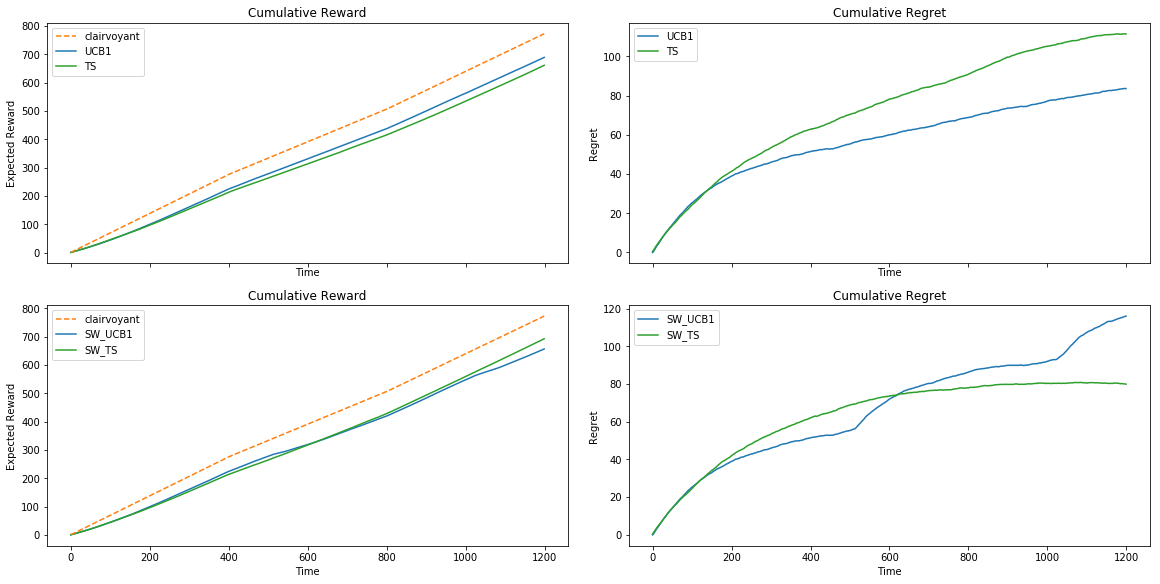

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8), sharex=True, constrained_layout=True)  
compare_results(ax[0], T, {"UCB1" : results["UCB1"], "TS" : results["TS"]}, clairvoyant)
compare_results(ax[1], T, {"SW_UCB1" : results["SW_UCB1"], "SW_TS" : results["SW_TS"]}, clairvoyant)
plt.show()

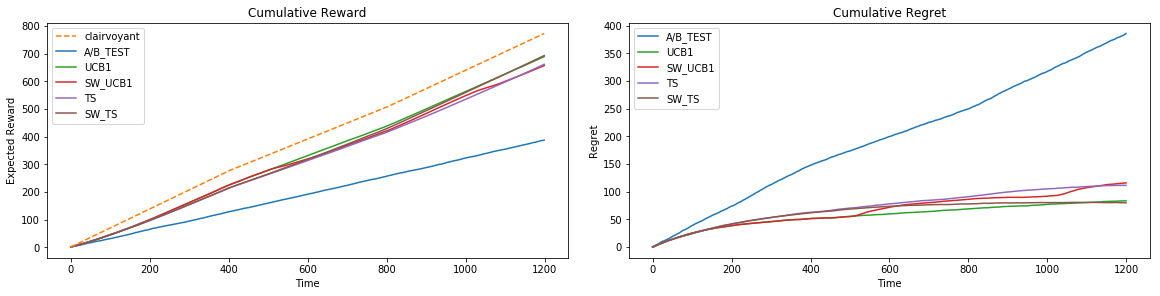

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, constrained_layout=True)
compare_results(ax, T, results, clairvoyant)
plt.show()

## Context Generation

* Notation

  $t$ time

  $l$ features, we assume each feature can have a binary value (e.g. for feature young, we have that a customer is either young or not)

  $F \subseteq \left\{0,1\right\}^l$ space of attributes

  $c \subseteq F$ context

  $\mathscr{P} = \left\{c : c \subseteq F, c \cup \varnothing, c \cap F\right\}$ context structure

  $a_{c}^*$ optimal arm for context $c$

  $X_{a,c}$ random variable (bernoulli) associated to arm a in context $c$

  $\mu_{a,c}$ expected value of random variable $X_{a,c}$

  $x_{a,c,t}$ realizations of $X_{a,c}$ at round $t$

  $\bar{x}_{a,c}$ empirical mean of $x_{a,c,t}$

  **Value of a context structure:**

  $v = \sum_{c \in \mathscr{P}}{p_{c} \mu_{a_{c}^*,c}}$

  **Split condition:**

  $\underline{p}_{c_{1}} \underline{\mu}_{a_{c_{1}}^*,c_{1}}+\underline{p}_{c_{2}} \underline{\mu}_{a_{c_{2}}^*,c_{2}} \geq \mu_{a_{c_{0}}^*,c_{0}}$

  Where:
  
  $\underline{p}_{c_{i}}$ is the lower bound of the probability of context $c_{i}$ and,
  
  $\underline{\mu}_{a_{c_{i}}^*}$ is the lower bound of the reward of the optimal arm ${a_{c}^*}$ in context $c_{i}$.
  
  **Lower bound:**

  The lower bound is calculated as the Hoeffding bound, that for Bernoulli distribution is:

  $\bar{x} - \sqrt{-\frac{log(\delta)}{2\mid Z\mid}}$

  where $\delta$ is the confidence and $Z$ is the dataset


* Algorithm
  
  * For every feature:
    
    * Split the context $c$ (according to the split condition defined before) if it's worth doing it
    
    * Evaluate the value $v$ of the context after the split
  
  * Select the feature with the highest value $v$ if larger than the non split case

In [22]:
context.N = 168
context.data = {'country' : [], 'age' : []}

np.random.seed(1234)
context_data = context.sample_users()

pd.DataFrame(context_data, index=pd.Index("User " + str(i+1) for i in range(len(context.data["country"])))).head()

,country,age
User 1,italy,old
User 2,usa,old
User 3,usa,young
User 4,italy,old
User 5,usa,old


In [23]:
context_summary = pd.DataFrame(context_data).pivot_table(values=['country','age'], index=['country','age'], aggfunc=lambda x: len(x))

pd.DataFrame(context_summary, columns=['#customers'])

#customers
country age              
italy   old            21
        young          27
usa     old            57
        young          63

In [24]:
context_value = context.split_context()
context_value

'usa'

## Results

We decided to apply the context generation algorithm each week, so we have 24 customers per day and then we check if it's worth splitting the context or not each $24 \times 7 = 168$ customers.

In [0]:
def run_experiment_with_context(context, learners, T, phases_len, verbose=False):
 
  clairvoyant = np.zeros((T))

  probabilities = list(context.avg_conversion_rates.values())

  envs = [[] for learner in range(len(learners))]
  
  for learner in range(len(learners)):
    envs[learner] = Non_Stationary_Environment(len(context.prices), probabilities=probabilities, horizon=T)
  
  old_context = None
  
  for t in range(T):
      
    italy = np.random.choice(np.linspace(0, 1, 1000))
    usa = 1 - italy

    young = np.random.choice(np.linspace(0, 1, 1000))
    old = 1 - young

    context.features["country"] = {'italy' : italy, 'usa' : usa}
    context.features["age"] = {'young' : young, 'old' : old}

    context.sample_users(N=1)
        
    if t % context.N == 0:
      
      context_value = context.split_context(int(t/phases_len))

      if context_value != old_context and verbose:
        if old_context != None:
          print("Context switch in week:", int(t/context.N) + 1, "from", old_context, "to", context_value,
                "\n(total customers = %d: ita = %d, usa = %d, young = %d, old = %d)" % (t + 1,
                                                                                       context.data["country"].count("italy"),
                                                                                       context.data["country"].count("usa"),
                                                                                       context.data["age"].count("young"),
                                                                                       context.data["age"].count("old")), "\n")
        else:
          print("Initial context:", context_value, "\n")
          
        old_context = context_value

    if context_value == 'aggregate':        
      probabilities = list(context.avg_conversion_rates.values())
      clairvoyant[t] = list(context.opt_avg_revenues.values())[int(t/phases_len)] / prices[list(context.opt_avg_revenues.values()).index(list(context.opt_avg_revenues.values())[int(t/phases_len)])]

    else:
      probabilities = []

      for season in context.conversion_rates.keys():
        probabilities.append(context.conversion_rates[season][context_value])

      clairvoyant[t] = np.array((list(context.opt_revenues.values())[int(t/phases_len)])[context_value]) / np.array(context.prices[np.argmax((list(context.revenues.values())[int(t/phases_len)])[context_value])])

    for learner in range(len(learners)):
      envs[learner].probabilities = probabilities

    for i, learner in enumerate(learners):
      pulled_arm = learner.pull_arm()
      reward = envs[i].round(pulled_arm)
      learner.update(pulled_arm, reward)

  return clairvoyant

def run_all_algorithms_with_context(context, T, n_experiments, phases_len, window_size, verbose=False):
  
  prices = context.prices
  
  results = {
    "UCB1" : [],
    "SW_UCB1" : [],
    "TS" : [],
    "SW_TS" : []
  }
 
  np.random.seed(1234)
  
  arms = [[] for l in range(len(results))]
  rewards = [[] for l in range(len(results))]
  
  clairvoyant = []
  
  for i in range(n_experiments):
    
    context.data = {'country' : [], 'age' : []}
    
    if i == 0:
      vverbose = True
    else:
      vverbose = False
    
    learners = [UCB1_Learner(n_arms=len(prices), arms=prices),
               SW_UCB1_Learner(n_arms=len(prices), arms=prices, window_size=window_size),
               TS_Learner(n_arms=len(prices), arms=prices),
               SW_TS_Learner(n_arms=len(prices), arms=prices, window_size=window_size)]
    
    clairvoyant.append(run_experiment_with_context(context, learners, T, phases_len, vverbose))
    
    for learner in learners:
      arms[learners.index(learner)].append(learner.arm_pulled)
      rewards[learners.index(learner)].append(learner.rewards)

  if verbose:
    for i in range(len(learners)):
      plot_results(T, phases_len, n_experiments, np.array(np.mean(rewards[i], axis=0)), np.mean(clairvoyant, axis=0), np.array(arms[i]), len(prices), list(results.keys())[i])
  
  for l in range(len(learners)):
    results[list(results.keys())[l]].append(np.mean(rewards[l], axis=0))
  
  fig, ax = plt.subplots(2, 2, figsize=(16, 8), sharex=True, constrained_layout=True)  
  compare_results(ax[0], T, {"UCB1" : results["UCB1"], "TS" : results["TS"]}, np.mean(clairvoyant, axis=0))
  compare_results(ax[1], T, {"SW_UCB1" : results["SW_UCB1"], "SW_TS" : results["SW_TS"]}, np.mean(clairvoyant, axis=0))
  plt.show()
  
  fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, constrained_layout=True)  
  compare_results(ax, T, results,  np.mean(clairvoyant, axis=0))
  plt.show()
  
  return results, np.mean(clairvoyant, axis=0)

Initial context: aggregate 

Context switch in week: 2 from aggregate to usa 
(total customers = 169: ita = 86, usa = 83, young = 82, old = 87) 

Context switch in week: 5 from usa to italy 
(total customers = 673: ita = 344, usa = 329, young = 340, old = 333) 



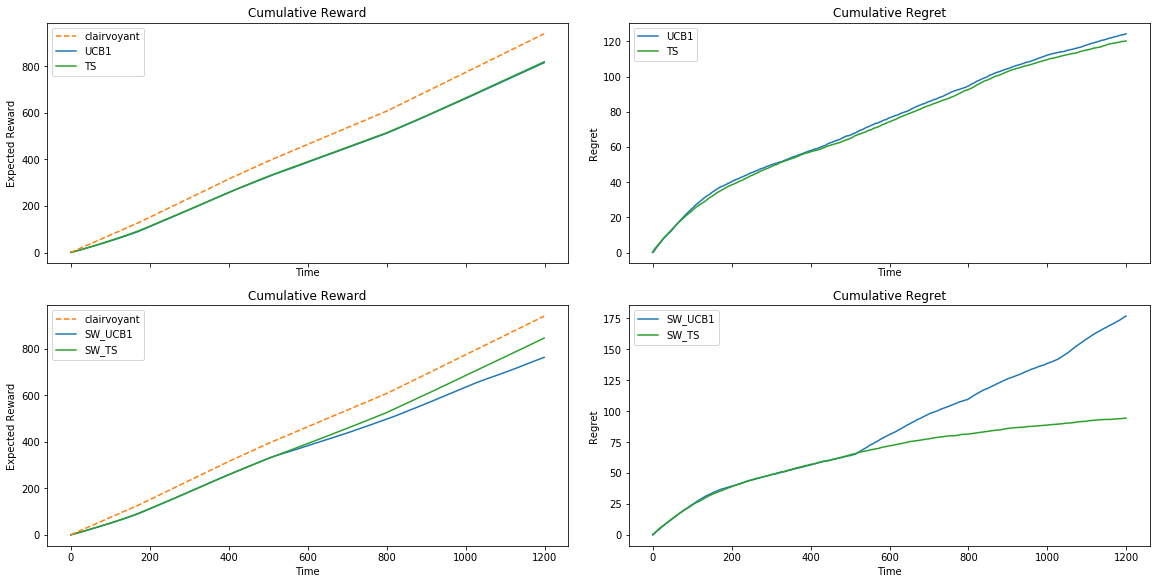

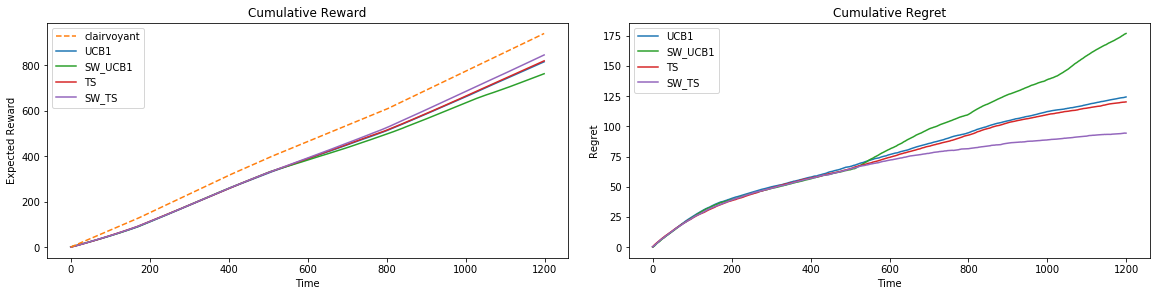

In [26]:
# takes very long time because it runs all the 4 bandits and then compare their results
# setting verbose = True will output every context switch and could be really verbose
n_experiments = 100
contextual_results, contextual_clairvoyant = run_all_algorithms_with_context(context, T, n_experiments, phases_len, window_size, verbose=verbose)

### Comparison with the results of non contextual versions

In general, when compared with the non contextual version of the algorithms the gain in regret/reward is very significant.

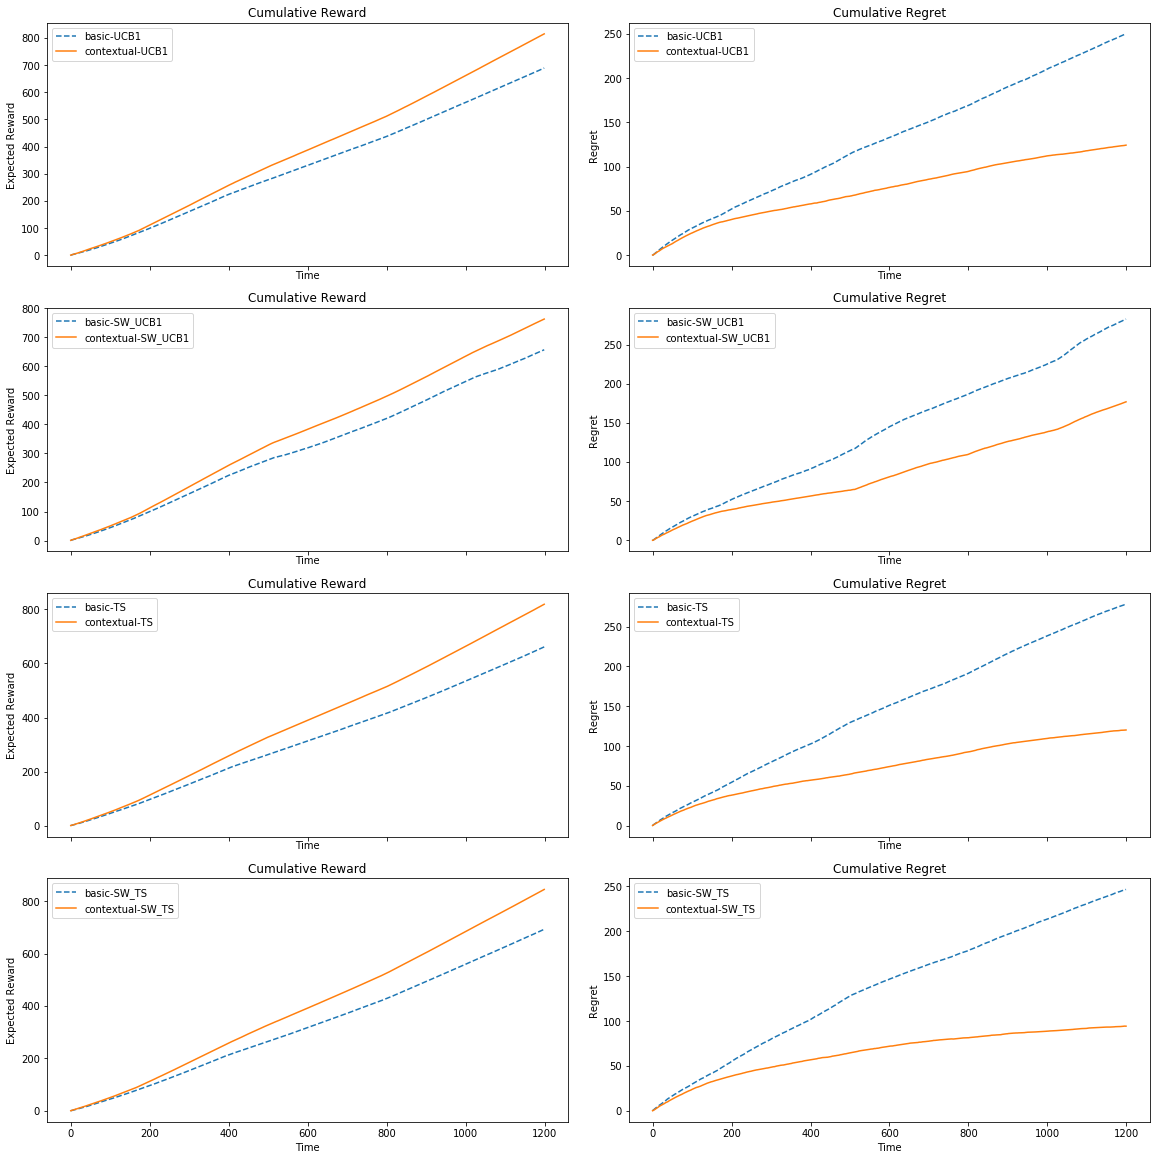

In [27]:
fig, ax = plt.subplots(4,2, figsize=(16,16), sharex=True, constrained_layout=True)

if "A/B_TEST" in results.keys():
  results.pop("A/B_TEST")

for i, algorithm in enumerate(results.keys()):
  
  r = {"basic-"+algorithm : results[algorithm],
       "contextual-"+algorithm : contextual_results[algorithm]}

  c = {"basic-"+algorithm : contextual_clairvoyant,
      "contextual-"+algorithm : contextual_clairvoyant}
  
  for version in r.keys():
    if version == 'basic-'+algorithm:
      fmt = '--'
    else:
      fmt = '-'
      
    ax[i][0].plot(range(T), np.cumsum(r[version]), fmt, label=version)
  
    if version == 'basic-'+algorithm:
        fmt = '--' 
    else:
      fmt = '-'
      
    ax[i][1].plot(range(T), np.cumsum(np.array(c[version]) - np.array(r[version])), fmt, label=version)
    
  ax[i][0].set_title("Cumulative Reward")
  ax[i][0].set_xlabel('Time')
  ax[i][0].set_ylabel('Expected Reward')
  ax[i][0].legend()

  ax[i][1].set_title("Cumulative Regret")
  ax[i][1].set_xlabel('Time')
  ax[i][1].set_ylabel('Regret')
  ax[i][1].legend()